# Week of 2025.05.05 

**Goals for the week:**
- [ ] Atmosphere integration 
    - [x] Correspond with Fred to better understand how the atmospheric coupling works and debug the weird artifacts I am currently getting. 
    - [x] Compare numerical results to rough analytical calculation based on this [paper](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2021JB021940). Use the rough calculation to also get the sense whether our current model is on the right order.  
    - [x] review analytical model and make sure everything is adjusted for high elevation. Not everything was adjusted for the high elevation. Now the data matches up. 
    - [ ] Consider updating model to make use of Lighthill stress tensor. 
    - [x] try turning off gravity + get rid of intitial 

- [ ] Lighthill acoustic analogy theory 
    - [ ] Figure out where Fred's code was for calculating the source term (i.e. Lighthill stress tensor).
    - [ ] Write out Green's function.
    - [ ] Figure out how to compute Green's function. 

- [ ] Fragmentation front investigation 
    - [ ] Currently the fragmentation starts a second front in the middle of the melt. Understand and debug this. 
    - [ ] Mario found that increasing the partial water density improved the situation. 
    - [ ] Increase exsolution time scale. 
    - [ ] Different fragmentation criteria, maybe consider using something other than strain. 

- [ ] Review Steady state solution 
    - [ ] Make sure you understand where the steady state is coming from. 

**Questions that arise:**


## 0.0 Calling steady state

So far, I have been relying on Mario to run the steady state code. However, I think it is probably worth knowing how to run it myself and double checking the initial conditions. It appears to me that the steady state output may not totally line up with the steady state in the quail numerical code. 

## 1.0 Review current state of volcano eruption

In [62]:
from helper_code.slip_imports import *
from helper_code.helper_functions import get_local_solver_from_index_func
from helper_code.animate import animate_conduit_pressure

folder_name = "eruption_model"
file_name = "tungurahua_rad_5_v25_conduit"
iterations = 100

In [63]:
solver_func = get_local_solver_from_index_func(folder_name, file_name)
ani = animate_conduit_pressure(solver_func, iterations=iterations, viscosity_index=1, wall_friction_index=5, max_velocity=50, max_slip=60, max_tau=0.1, max_pressure=50, max_speed_of_sound=2000, max_water=20, max_density=5e3, max_fragmentation=5000, max_crystal=100, max_viscosity=1)

HTML(ani.to_html5_video())

## 2.0 Simple analytical model to predict atmospheric pressure

The downside of the atmospheric coupling in quail is that the model is complicated and I don't fully understand it. As a small project, I am going to create a simple numerical solution for atmosphere based on treating the volcano as a monopole acoustic source where the pressure wave is a function purely of the ejected volume, which we consider to be incompressible. 

Eric shared [notes](https://drive.google.com/file/d/1khrmHWfoOqrcBjE533TtZirvnp9IIAc3/view?usp=sharing) on 3D acoustics, from which I will use the relation 

$$
p(r,t) = \frac{\rho \dot{Q}(t-r/c)}{4 \pi r * (2/3)}
$$



Where $Q(t)$ is volumetric flow. Let's quickly check units

$$
\frac{[\frac{kg}{m^3}] [\frac{m^3}{s^2}]}{[m]} = [\frac{kg}{m s^2}] = [Pa]
$$

To create a simple model for pressure as a function of time and radius. The $2/3$ factor comes from the fact that the volcano occupies 1/3 of the angular space around the monopole source. Note that $Q(t)$ is volume outflow, which in our situation can be expressed as 

$$ Q(t) = \dot{s} \pi  r^2 $$

and the derivative can be expressed 

$$ \dot{Q}(t) = \ddot{s} \pi r^2$$

Where $\dot{s}$ is the derivative of slip, or simply velocity. 

We also need to know both the speed of sound $c$ and $\rho$ both of which are functions of altitutde. From Wikipedia, 

$$ p = p_0 *\exp(- \frac{g * h *M}{T_O * R_0})$$

Note, $h$ is elevation above sea level.

**Constants:**
- $T_0 = 288.15 [K]$ (sea level temp)
- $ M = 0.02896968 [kg/mol]$ (Molar mass of dry air)
- $R_0 = 8.314462618 [J/(mol·K)]$ (gas constant)
- $p_0 = 101,325 [Pa]$ (pressure at sea level).
- $c = 320 [m/s]$ (speed of sound, we will define as a constant for now)

In [20]:
T_0 = 288.15 # [K]
M = 0.02896968 # [kg/mol]
R_0 = 8.314462618 #[J/(mol·K)]
p_0 = 101325 # [Pa]
g = 9.81 # [m/s^2]

SUMMIT_TUNGURAHUA = 5023 # [m]

L = 0.0065    # Temperature lapse rate (K/m)
gamma = 1.4   # Specific heat ratio for air

def pressure():
    return p_0 * np.exp(-M * g * (SUMMIT_TUNGURAHUA) / (R_0 * T_0)) # [Pa]

def density():
    T = T_0 - L * (SUMMIT_TUNGURAHUA)
    P = pressure()

    return P / (R_0 * T)

def sound_speed():
    return 320 #[m/s] estimated speed of sound in air at 5000m

def point_in_volcano(x, y):
    # Define the volcano shape
    # This is a placeholder function; replace with actual volcano shape logic
    if y < -1/2 * x and y < 1/2 * x:
        return True
    else:
        return False

In [ ]:
from scipy.interpolate import interp1d

solver_func = get_local_solver_from_index_func(folder_name, file_name)

u_vec = []
t_vec = []
R = 50 # m

for i in range(0, int(iterations), 1):
    solver = solver_func(i)
    momentum = solver.state_coeffs[:,:,solver.physics.get_momentum_slice()]
    rho = np.sum(solver.state_coeffs[:, :, solver.physics.get_mass_slice()],axis=2,keepdims=True)

    # Define velocity as momentum divided by density. "velocity" when computed as an additional state variable appears to be an absolute value. 
    u = momentum.ravel() / rho.ravel()

    # Take only the exit velocity
    u_vec.append(np.maximum(u[-1], 0))
    t_vec.append(solver.time)

a_vec = np.gradient(np.array(u_vec), np.array(t_vec))

Q_dot = np.pi * R**2 * a_vec # m^3/s^2

def Q_dot_func(t):
    if t < t_vec[0] or t > t_vec[-1]:
        return 0
    
    # Create interpolator for each grid point
    interpolator = interp1d(t_vec, Q_dot, kind='linear', fill_value="extrapolate")
    
    # Evaluate at time t
    interpolated_Q = interpolator(t)
    
    # Linear interpolation
    return interpolated_Q


def relative_pressure(t, x, y):
    r = np.sqrt(x**2 + y**2)
    rho = density()

    # 2/3 comes from the fact that 1/3 of the outward area is solid volcano
    return rho * Q_dot_func(t - r / sound_speed()) / ((2/3) * np.pi * 4 * r)

In [22]:
from matplotlib.animation import FuncAnimation

N = 100
pressure_array = np.zeros((N, N))
x_low, x_upper = -500, 3000
y_low, y_upper = -1000, 2500

# Set up the figure and axis
fig, ax = plt.subplots()
im = ax.imshow(pressure_array, extent=[x_low, x_upper, y_low, y_upper], 
               aspect='auto', cmap='jet', origin='lower', vmin=0, vmax=1500)
plt.colorbar(im, label='Pressure (Pa)')
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_title('Pressure Distribution Over Time')

# Initialization function for animation
def init():
    im.set_array(np.zeros((N, N)))
    return [im]

# Animation update function
def update(t):
    for i in range(N):
        for j in range(N):
            x = x_low + (x_upper - x_low) * i / N
            y = y_low + (y_upper - y_low) * j / N

            if point_in_volcano(x, y):
                pressure_array[j][i] = 0  # Set pressure to 0 inside volcano
            else:
                pressure_array[j][i] = relative_pressure(t, x, y)

    im.set_array(pressure_array)
    ax.set_title(f'Pressure Distribution at t={t:.2f} s')
    return [im]

# Create animation
ani = FuncAnimation(fig, update, init_func=init, frames=np.asarray(t_vec[0:int(iterations)]), 
                    interval=200, blit=True)

display(HTML(ani.to_html5_video()))
plt.close(fig)  # Clean up


In [23]:
pressure_at_500 = []
pressure_at_1000 = []
pressure_at_1500 = []
pressure_at_2000 = []

for t in t_vec:
    pressure_at_500.append(relative_pressure(t, 500, -250))
    pressure_at_1000.append(relative_pressure(t, 1000, -500))
    pressure_at_1500.append(relative_pressure(t, 1500, -750))
    pressure_at_2000.append(relative_pressure(t, 2000, -1000))

Text(0.02, 0.5, 'Pressure (Pa)')

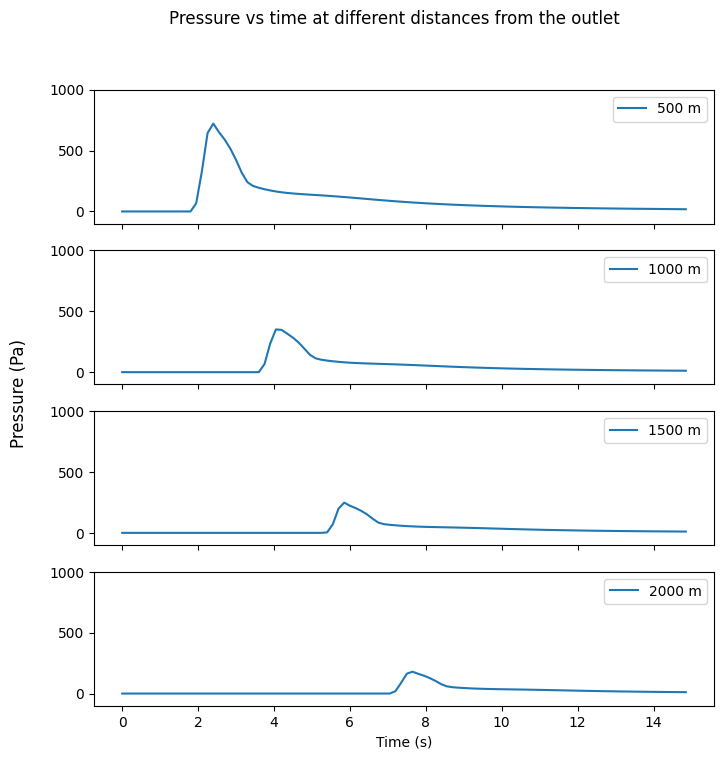

In [44]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(8, 8), sharex=True)

axes[0].plot(t_vec, pressure_at_500, label="500 m")
axes[1].plot(t_vec, pressure_at_1000, label="1000 m")
axes[2].plot(t_vec, pressure_at_1500, label="1500 m")
axes[3].plot(t_vec, pressure_at_2000, label="2000 m")

for ax in axes:
    ax.set_ylim(-100, 1000)
    ax.legend()

axes[-1].set_xlabel("Time (s)")

fig.suptitle("Pressure vs time at different distances from the outlet")
fig.supylabel("Pressure (Pa)")

Now, let's look at what the graph looks like when we pass it through a high pass filter and only support frequencies above 1Hz. 

Text(0.5, 0.98, 'Pressure Time Series at Different Distances from the outlet')

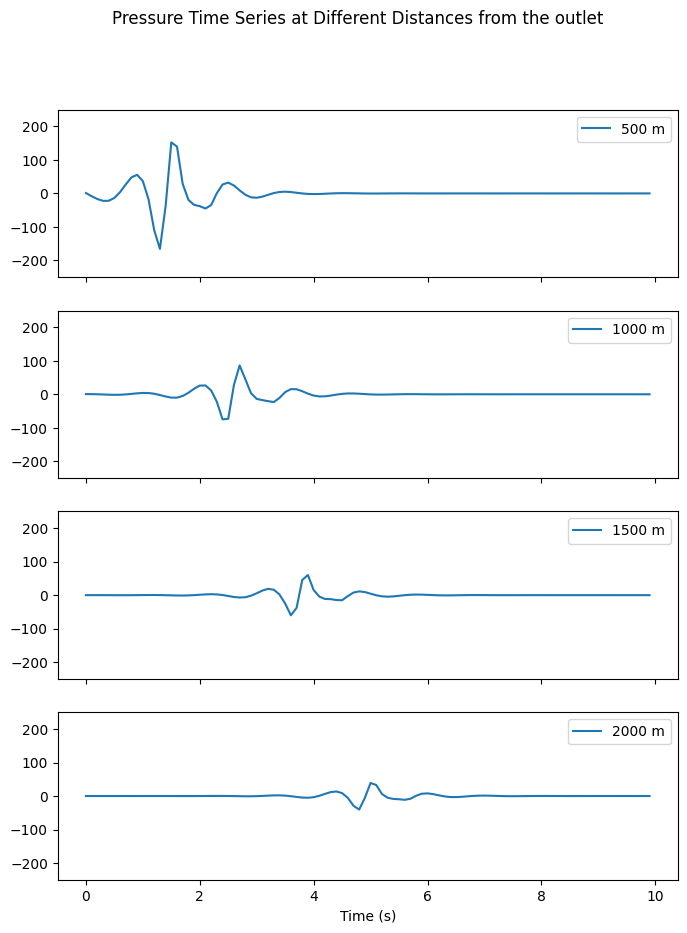

In [43]:
from scipy import signal

fs = 10  # Sampling frequency (Hz)

# Step 2: Define band-pass filter parameters
lowcut = 1.0  # Lower cutoff frequency (Hz)
order = 5  # Filter order

# Normalize cutoff frequencies to Nyquist frequency (fs/2)
nyquist = 0.5 * fs
low = lowcut / nyquist

# Step 3: Design Butterworth band-pass filter
b, a = signal.butter(order, low, btype='high')

p_relative_arr_500_filtered = signal.filtfilt(b, a,  pressure_at_500)
p_relative_arr_1000_filtered = signal.filtfilt(b, a,  pressure_at_1000)
p_relative_arr_1500_filtered = signal.filtfilt(b, a, pressure_at_1500)
p_relative_arr_2000_filtered = signal.filtfilt(b, a, pressure_at_2000)

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(8, 10), sharex=True)

axes[0].plot(np.arange(0, iterations*(1/10), 1/10), p_relative_arr_500_filtered, label="500 m")
axes[1].plot(np.arange(0, iterations*(1/10), 1/10), p_relative_arr_1000_filtered, label="1000 m")
axes[2].plot(np.arange(0, iterations*(1/10), 1/10), p_relative_arr_1500_filtered, label="1500 m")
axes[3].plot(np.arange(0, iterations*(1/10), 1/10), p_relative_arr_2000_filtered, label="2000 m")

for ax in axes:
    ax.set_ylim(-2.5e2, 2.5e2)
    ax.legend()
    
plt.xlabel("Time (s)")
fig.suptitle("Pressure Time Series at Different Distances from the outlet")


## 3.0 Observed infrasound data

The infrasound data can be found [here](https://agupubs.onlinelibrary.wiley.com/doi/10.1002/2017GL076419). Well actually, I was unable to find a good way to download it from that link, but Mario shared this [google folder](https://drive.google.com/file/d/1uE-DbUshRbbkA-Hd7m-4wGWKaa8iPmGi/view?usp=drive_link) with me.

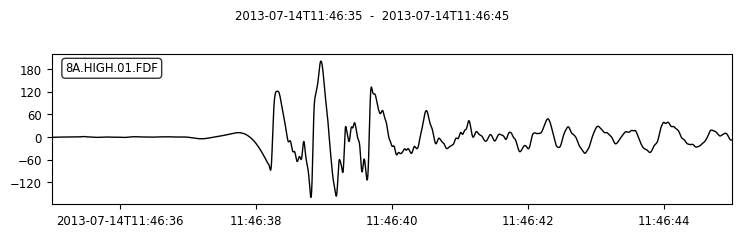

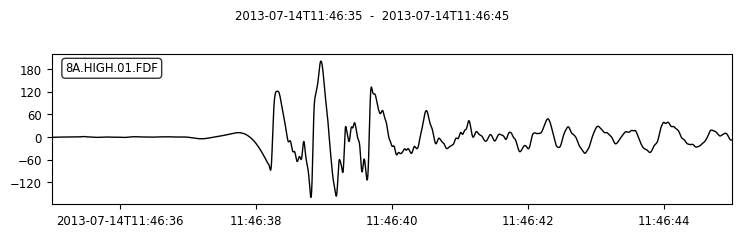

In [61]:
import matplotlib.pyplot as plt
import numpy as np

import obspy
from obspy import read, Stream, UTCDateTime
from obspy.io.mseed.util import get_record_information

file_path = "/Users/paxton/git/volcano_sims/infrasound_data/8A.HIGH.2013-07-14.mseed"

st = read(file_path)

tr0 = st[0]
tr0_filtered = tr0.copy()

freqmin = 1
freqmax = 20
tr0_filtered.filter("bandpass", freqmin=freqmin, freqmax=freqmax, corners=4, zerophase=True)

tr0_filtered.data = tr0_filtered.data * 1.589e-6 /  23e-6

t1 = UTCDateTime("2013-07-14T11:46:35")
t2 = UTCDateTime("2013-07-14T11:46:45")

tr0_filtered.trim(t1, t2)

tr0_filtered.plot()

## 4.0 Reviewing quail atmosphere model (r1 + r2 + r3)

I reduced the order of solution to **order 0** below. 

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.colors as colors
import numpy as np
import processing.mdtools as mdtools

iterations = 100

# Assume solver2D_from is available as in the original code
solver2D_atm1 = get_local_solver_from_index_func("eruption_model", "test_infrasound_v22_atm1")
solver2D_atm2 = get_local_solver_from_index_func("eruption_model", "test_infrasound_v22_atm2")
solver2D_atm3 = get_local_solver_from_index_func("eruption_model", "test_infrasound_v22_atm3")

# Set up figure
fig = plt.figure(figsize=(8, 6))

# Define pressure range for colormap
clims = (-1e2, 1e3)

# Initialize with first frame (index 0)
x1, p1 = mdtools.downsample(solver2D_atm1(0), plot_qty="Pressure")
p1_0 = p1.copy()  # Store initial pressure for reference
mdtools.plot_mean(x1, p1, clims)

x2, p2 = mdtools.downsample(solver2D_atm2(0), plot_qty="Pressure")
p2_0 = p2.copy()  # Store initial pressure for reference
# Plot the initial pressure field
mdtools.plot_mean(x2, p2, clims)

x3, p3 = mdtools.downsample(solver2D_atm3(0), plot_qty="Pressure")
p3_0 = p3.copy()  # Store initial pressure for reference
# Plot the initial pressure field
mdtools.plot_mean(x3, p3, clims)

# Set up colorbar
sm = plt.cm.ScalarMappable(
    norm=colors.Normalize(vmin=clims[0], vmax=clims[1]),
    cmap=plt.get_cmap()
)
cb = plt.colorbar(sm, ax=plt.gca())
cb.set_label("Pressure (Pa), hydrostatic removed")

# Animation update function
def update(frame):
    plt.cla()  # Clear current axis
    # Fetch data for current frame
    x1, p1= mdtools.downsample(solver2D_atm1(frame), plot_qty="Pressure")
    x2, p2 = mdtools.downsample(solver2D_atm2(frame), plot_qty="Pressure")
    x3, p3 = mdtools.downsample(solver2D_atm3(frame), plot_qty="Pressure")
    # Update plot
    mdtools.plot_mean(x1, p1-p1_0, clims)
    mdtools.plot_mean(x2, p2-p2_0, clims)
    mdtools.plot_mean(x3, p3-p3_0, clims)
    plt.title(f"Pressure Field at Sec {round(0.1 * frame)}")
    return plt.gca(),

# Create animation
# Assume 100 frames for simulation; adjust based on solver data
ani = animation.FuncAnimation(
    fig,
    update,
    frames=range(0, iterations, 1),  # Adjust range based on available solver indices
    interval=100,  # Time between frames in milliseconds
    blit=False
)

display(HTML(ani.to_html5_video()))
plt.close(fig)  # Clean up

In [6]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.colors as colors
import numpy as np
import processing.mdtools as mdtools

iterations = 50

# Assume solver2D_from is available as in the original code
solver2D_atm1 = get_local_solver_from_index_func("eruption_model", "test_infrasound_v22_atm1")
solver2D_atm2 = get_local_solver_from_index_func("eruption_model", "test_infrasound_v22_atm2")
solver2D_atm3 = get_local_solver_from_index_func("eruption_model", "test_infrasound_v22_atm3")

# Set up figure
fig = plt.figure(figsize=(8, 6))

# Define pressure range for colormap
clims = (-3, 5)

# Set up colorbar
sm = plt.cm.ScalarMappable(
    norm=colors.Normalize(vmin=clims[0], vmax=clims[1]),
    cmap=plt.get_cmap()
)
cb = plt.colorbar(sm, ax=plt.gca())
cb.set_label("Velocity (m/s)")

# Animation update function
def update(frame):
    plt.cla()  # Clear current axis
    # Fetch data for current frame
    x1, v1= mdtools.downsample(solver2D_atm1(frame), plot_qty="XVelocity")
    x2, v2 = mdtools.downsample(solver2D_atm2(frame), plot_qty="XVelocity")
    x3, v3 = mdtools.downsample(solver2D_atm3(frame), plot_qty="XVelocity")
    # Update plot
    mdtools.plot_mean(x1, v1, clims)
    mdtools.plot_mean(x2, v2, clims)
    mdtools.plot_mean(x3, v3, clims)
    plt.title(f"Velocity Field at Sec {round(0.1 * frame)}")
    return plt.gca(),

# Create animation
# Assume 100 frames for simulation; adjust based on solver data
ani = animation.FuncAnimation(
    fig,
    update,
    frames=range(0, iterations, 1),  # Adjust range based on available solver indices
    interval=100,  # Time between frames in milliseconds
    blit=False
)

display(HTML(ani.to_html5_video()))
plt.close(fig)  # Clean up

In [75]:
import matplotlib.tri as tri

def find_elem_ID(x, y, trifinders):
  ''' Returns element ID corresponding to given x and y. '''

  trifinders_at_point = [trifinders[0](x, y), trifinders[1](x, y), trifinders[2](x, y)]

  elem_ID = max(trifinders_at_point)
  index = trifinders_at_point.index(elem_ID)

  return index, elem_ID

def get_p_series(x_target, y_target, solver2D_1, solver2D_2, solver2D_3, trifinders):

  # Find the element ID
  index, elem_ID = find_elem_ID(x_target, y_target, trifinders)

  print(f"Element ID for point ({x_target}, {y_target}): {elem_ID}")

  p_relative_arr = []
  p0 = None

  for i in range(0, iterations):
      # Get the solver state at the current time step
      solvers = [solver2D_1(i), solver2D_2(i), solver2D_3(i)]

      U = solvers[index].state_coeffs
      U_target = U[elem_ID:elem_ID+1]

      # Compute pressure using the state vector
      p_target = solvers[index].physics.compute_variable("Pressure", U_target)

      if i == 0:
          p0 = np.average(p_target)

      p_relative_arr.append(np.average(p_target) - p0)
  
  return p_relative_arr

### 4.1 Try removing gravity and start with homogenous atmosphere 

This data seems sufficiently noisy I am not sure what exactly we can get from it. 

If we remove the gravity source term, and use a homogenous enviornment for the initial conditions, the atmosphere simulation cleans up nicely. 

In [64]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.colors as colors
import numpy as np
import processing.mdtools as mdtools

iterations = 100

# Assume solver2D_from is available as in the original code
solver2D_atm1 = get_local_solver_from_index_func("eruption_model", "test_infrasound_v26_atm1")
solver2D_atm2 = get_local_solver_from_index_func("eruption_model", "test_infrasound_v26_atm2")
solver2D_atm3 = get_local_solver_from_index_func("eruption_model", "test_infrasound_v26_atm3")

# Set up figure
fig = plt.figure(figsize=(8, 6))

# Define pressure range for colormap
clims = (-1e3, 1e3)

# Set up colorbar
sm = plt.cm.ScalarMappable(
    norm=colors.Normalize(vmin=clims[0], vmax=clims[1]),
    cmap=plt.get_cmap()
)
cb = plt.colorbar(sm, ax=plt.gca())
cb.set_label("Pressure (Pa)")
x1, p1_0= mdtools.downsample(solver2D_atm1(0), plot_qty="Pressure")
x2, p2_0 = mdtools.downsample(solver2D_atm2(0), plot_qty="Pressure")
x3, p3_0 = mdtools.downsample(solver2D_atm3(0), plot_qty="Pressure")

# Animation update function
def update(frame):
    plt.cla()  # Clear current axis
    # Fetch data for current frame
    x1, p1= mdtools.downsample(solver2D_atm1(frame), plot_qty="Pressure")
    x2, p2 = mdtools.downsample(solver2D_atm2(frame), plot_qty="Pressure")
    x3, p3 = mdtools.downsample(solver2D_atm3(frame), plot_qty="Pressure")
    # Update plot
    mdtools.plot_mean(x1, p1 - p1_0, clims)
    mdtools.plot_mean(x2, p2 - p2_0, clims)
    mdtools.plot_mean(x3, p3 - p3_0, clims)
    plt.title(f"Pressure Field at Sec {round(0.1 * frame)}")
    return plt.gca(),

# Create animation
# Assume 100 frames for simulation; adjust based on solver data
ani = animation.FuncAnimation(
    fig,
    update,
    frames=range(0, iterations, 1),  # Adjust range based on available solver indices
    interval=100,  # Time between frames in milliseconds
    blit=False
)

display(HTML(ani.to_html5_video()))
plt.close(fig)  # Clean up

In [81]:
import matplotlib.tri as tri

# Assume solver2D_from is available as in the original code
solver2D_1 = get_local_solver_from_index_func("eruption_model", "test_infrasound_v26_atm1")
solver2D_2 = get_local_solver_from_index_func("eruption_model", "test_infrasound_v26_atm2")
solver2D_3 = get_local_solver_from_index_func("eruption_model", "test_infrasound_v26_atm3") 


triangulation1 = tri.Triangulation(solver2D_1(0).mesh.node_coords[...,0],
                  solver2D_1(0).mesh.node_coords[...,1], 
                  triangles=solver2D_1(0).mesh.elem_to_node_IDs)

triangulation2 = tri.Triangulation(solver2D_2(0).mesh.node_coords[...,0],
                  solver2D_2(0).mesh.node_coords[...,1], 
                  triangles=solver2D_2(0).mesh.elem_to_node_IDs)

triangulation3 = tri.Triangulation(solver2D_3(0).mesh.node_coords[...,0],
                  solver2D_3(0).mesh.node_coords[...,1], 
                  triangles=solver2D_3(0).mesh.elem_to_node_IDs)
                  
trifinder1 = triangulation1.get_trifinder()
trifinder2 = triangulation2.get_trifinder()
trifinder3 = triangulation3.get_trifinder()

trifinders = [trifinder1, trifinder2, trifinder3]

p_relative_arr_200 = get_p_series(200, 0, solver2D_1, solver2D_2, solver2D_3, trifinders)
p_relative_arr_500 = get_p_series(500, 0, solver2D_1, solver2D_2, solver2D_3, trifinders)
p_relative_arr_1500 = get_p_series(1500, 0, solver2D_1, solver2D_2, solver2D_3, trifinders)
p_relative_arr_2000 = get_p_series(2000, 0, solver2D_1, solver2D_2, solver2D_3, trifinders)

Element ID for point (200, 0): 92
Element ID for point (500, 0): 714
Element ID for point (1500, 0): 785
Element ID for point (2000, 0): 960


Text(0.5, 0.98, 'Pressure Time Series at Different Distances from the outlet')

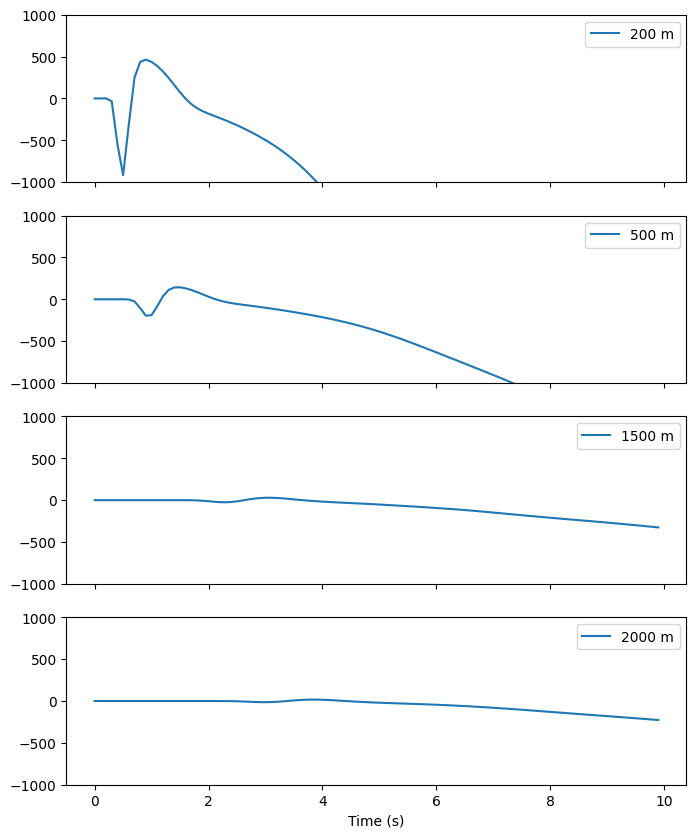

In [82]:
ig, axes = plt.subplots(nrows=4, ncols=1, figsize=(8, 10), sharex=True)

axes[0].plot(np.arange(0, iterations*(1/10), 1/10), p_relative_arr_200, label="200 m")
axes[1].plot(np.arange(0, iterations*(1/10), 1/10), p_relative_arr_500, label="500 m")
axes[2].plot(np.arange(0, iterations*(1/10), 1/10), p_relative_arr_1500, label="1500 m")
axes[3].plot(np.arange(0, iterations*(1/10), 1/10), p_relative_arr_2000, label="2000 m")

for ax in axes:
    ax.set_ylim(-1e3, 1e3)
    ax.legend()
    
plt.xlabel("Time (s)")
fig.suptitle("Pressure Time Series at Different Distances from the outlet")

### With a bandpass

Let's just see what that data looks like when we apply a bandpass filter to it.

In [79]:
from scipy import signal

fs = 10  # Sampling frequency (Hz)

# Step 2: Define band-pass filter parameters
lowcut = 1.0  # Lower cutoff frequency (Hz)
order = 5  # Filter order

# Normalize cutoff frequencies to Nyquist frequency (fs/2)
nyquist = 0.5 * fs
low = lowcut / nyquist

# Step 3: Design Butterworth band-pass filter
b, a = signal.butter(order, low, btype='high')

p_relative_arr_200_filtered = signal.filtfilt(b, a, p_relative_arr_200)
p_relative_arr_500_filtered = signal.filtfilt(b, a, p_relative_arr_500)
p_relative_arr_1500_filtered = signal.filtfilt(b, a, p_relative_arr_1500)
p_relative_arr_2000_filtered = signal.filtfilt(b, a, p_relative_arr_2000)

Text(0.5, 0.98, 'Pressure Time Series at Different Distances from the outlet')

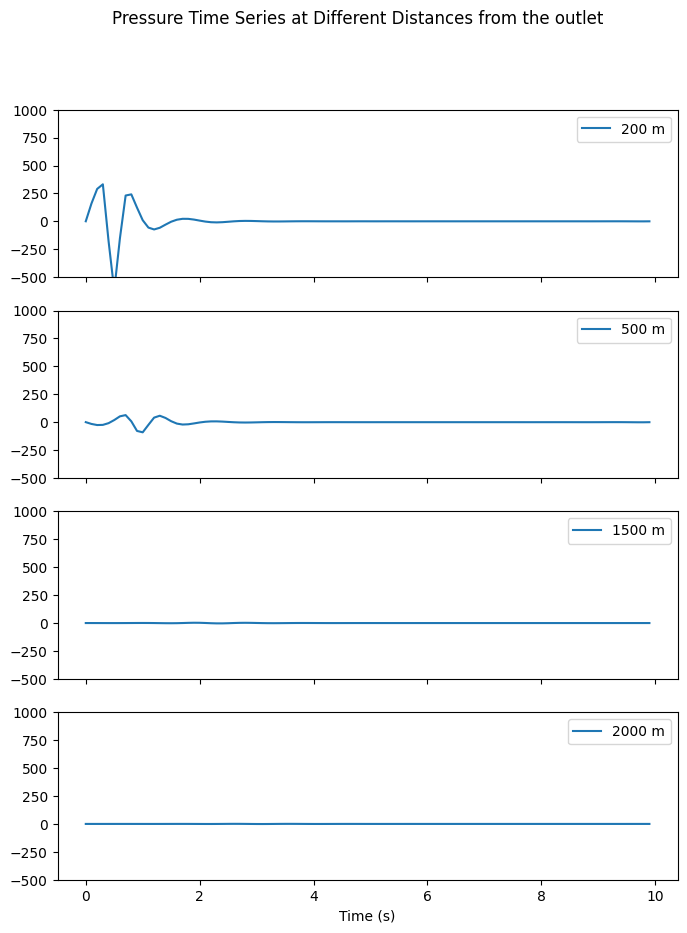

In [80]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(8, 10), sharex=True)

axes[0].plot(np.arange(0, iterations*(1/10), 1/10), p_relative_arr_200_filtered, label="200 m")
axes[1].plot(np.arange(0, iterations*(1/10), 1/10), p_relative_arr_500_filtered, label="500 m")
axes[2].plot(np.arange(0, iterations*(1/10), 1/10), p_relative_arr_1500_filtered, label="1500 m")
axes[3].plot(np.arange(0, iterations*(1/10), 1/10), p_relative_arr_2000_filtered, label="2000 m")

for ax in axes:
    ax.set_ylim(-5e2, 1e3)
    ax.legend()
    
plt.xlabel("Time (s)")
fig.suptitle("Pressure Time Series at Different Distances from the outlet")

# 5.0 Lighthill accostic analogy theory

From Eric: 

> If we wanted to get really ambitious, then what we could do is implement the Lighthill acoustic analogy theory. See section 3.6.2 in Fred's thesis, specifically equations (3.129) and (3.130). Fred has code to calculate the Lighthill stress tensor, which is a source term. We would then take that source term and convolve it with the linear acoustics Green's function. In fact, that could later be replaced with a fully coupled acoustic-elastic Green's function from another code (SPECFEM) that Mario has used. There are many reasons to do this: first, it only requires using Fred's code to get the flow field around the vent correctly, and it doesn't matter if there is too much damping in the numerics to accurately model acoustic propagation beyond a few hundred meters. Second, we know that the ground is not rigid, but elastic, as Fred's code assumes. The acoustic-elastic Green's functions will allow us to use all parts of the seismograms (right now we ignore the displacements caused by the strong infrasound blast). Mario and I have discussed this as a possible extension of his work.

### Notes on Lighthill Accoustic Analogy,  [Fred's thesis ](https://drive.google.com/drive/folders/1xwnqopoice-zy-8HfxhxLIeNJFAgZX5L) section 3.6.2

- Fred models 2150m conduit with 50m radius 
- Model the top 150m of the conduit as part of a axissymmetric 2d domain. 

Interestingly, Fred was able to get his model to create a burst of pressure of the right order of magnitude for the Tungurahua eruption:

> In comparison, our model prediction for
a sensor placed at a similar location on the flank 2 km from the vent produces a pressure peak of
a similar duration and order of magnitude as the Tungurahua Vulcanian blast, despite not having
tuned our parameters to fit the Tungurahua eruption.

Light hill's acoustic analogy is established by manipulating the governing equation for compresable flow to obtain 

$$
\frac{1}{a_0^2} \frac{\partial^2p}{\partial t^2} - \nabla^2 p = \nabla \cdot (\nabla \cdot \bf{T})
$$

where $a_0$ is the speed of sound in the atmosphere and $\bf{T}$ is the Lighthill stres sensor. 

The inviscid Lighthill stress tensor comprises a convective term plus another nonlinear term.

$$
\bf{T} = \rho \bf{u} \otimes \bf{u} + (p - a_0^2 \rho) \bf{I}
$$

Note:

$\rho u_i u_j$ - Reynolds stress 

$p - a_0^2 \rho$ - Thermodynamic pressure term. 

As a simplification, we could assume $p = a_0^2 \rho$ which would allow us to calculate each element of the tensor as:

$$
T_{ij} = \rho u_i u_j
$$


### Notes from talking with Eric 05/07

**1. Define the source**

$$ \frac{1}{c_0^2} \frac{\partial^2p}{\partial t^2} - \nabla^2 p = S(\bf{x}, t) $$

**2. Compute Green's function**

First, let's review what a [Green's function](https://en.wikipedia.org/wiki/Green%27s_function) is. A Green's function allows us to rewrite the problem as a sum of source points.

$$ 
\frac{1}{c_0^2} \frac{\partial^2 G(\bf(x), \bf(y), t)}{\partial t^2} + \nabla^2 G = \delta^{(3)}(\bf{x} - \bf{y})\delta(t)
$$

The Green's function, written for all space looks something like

$$
G(\bf{x}, \bf{y}, t) = \frac{\delta(t - \frac{|\bf{x} - \bf{y}|}{c_0})}{2 \pi | \bf{x} - \bf{y}|}
$$
 
So the pressure at any given point can be expressed as 

$$
p(\bf{x}, t) = \int \int_V G(\bf{x}, \bf{y}, t-\tau) S(\bf{y}, \tau) d^3y d \tau
$$

**3. How do we evaluate the convolution numerically.**

We would probably work in the frequency domain. Tends to be easier. So

$$
p(\bf{x}, \omega) = \int_V G(\bf{x}, \bf{y}, \omega) S(\bf{y}, \tau) d^3y d
$$




Consider using reciprocity. Specfem. 

Fred has code to get the source term. Talk to him about using that. Then you just need to compute the Green's function and evaluate the convolution numerically. 

## 6.0 Verify that eruption with 10% less pressure than "steady state" does not erupt

The steady state solution tells us that the chamber pressure at steady state is 2.5e7 Pa. 

Experiementally, I find that if I increase pressure above 2.0e7 Pa in the dynamic quail simulation the eruption starts. 

I also increased $D_c=10$ up from 1. 

In [87]:
folder_name = "eruption_model_no_atmosphere"
file_name = "tungurahua_rad_5_v20_conduit"
iterations = 20
solver_func = get_local_solver_from_index_func(folder_name, file_name)
ani = animate_conduit_pressure(solver_func, iterations=iterations, viscosity_index=1, wall_friction_index=5, max_velocity=30, max_slip=60, max_tau=1.5, max_pressure=50, max_speed_of_sound=2000, max_water=20, max_density=5e3, max_fragmentation=5000, max_crystal=100, max_viscosity=1)

HTML(ani.to_html5_video())